In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mstats
import pystan

%matplotlib inline

In [2]:
plt.style.use('ggplot')

In [3]:
df = pd.read_excel('./data/multilevel_modeling.xlsx')

In [4]:
df.head()

,age,height,id
0,1,72.737927,1
1,3,85.694575,1
2,5,98.635829,1
3,8,117.302636,1
4,10,130.076144,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     105 non-null    int64  
 1   height  105 non-null    float64
 2   id      105 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 2.6 KB


In [6]:
df.describe()

,age,height,id
count,105.000000,105.000000,105.000000
mean,8.428571,116.861595,8.000000
std,5.577870,32.518645,4.341216
min,1.000000,67.164850,1.000000
25%,3.000000,87.851596,4.000000
50%,8.000000,115.290453,8.000000
75%,15.000000,149.742039,12.000000
max,17.000000,175.611581,15.000000


In [7]:
df.id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int64)

In [8]:
groups = df.groupby(df.id)

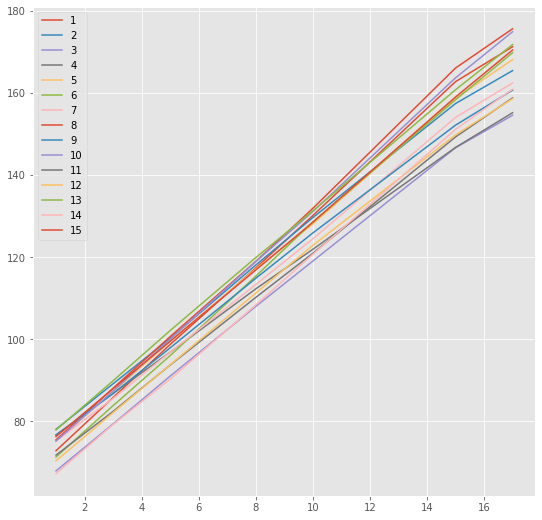

In [9]:
plt.figure(figsize=(9, 9))
for name, group in groups:
    plt.plot(group.age, group.height, label=name)
plt.legend()

In [10]:
type(groups), type(group)

(pandas.core.groupby.generic.DataFrameGroupBy, pandas.core.frame.DataFrame)

In [11]:
stan_model = """
data {
  int N;
  int N_id;
  real x[N];
  real Y[N];
  int<lower=1, upper=N_id> s_id[N];
}

parameters {
  real a0;
  real b0;
  real a_id[N_id];
  real b_id[N_id];
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_Y;
}

transformed parameters {
  real a[N_id];
  real b[N_id];
  for (n in 1:N_id) {
    a[n] = a0 + a_id[n];
    b[n] = b0 + b_id[n];
  }
}

model {
  for (id in 1:N_id) {
    a_id[id] ~ normal(0, s_a);
    b_id[id] ~ normal(0, s_b);
  }
  
  for (n in 1:N) {
    Y[n] ~ normal(a[s_id[n]] * x[n] + b[s_id[n]], s_Y);
  }
}

"""

In [12]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5b4070ef12fa6fd95ac34478619c78db NOW.


In [13]:
df.id.nunique()

15

In [14]:
stan_data = {'N':df.shape[0], 'N_id':df.id.nunique(), 'x':df.age, 'Y':df.height, 's_id':df.id}

In [18]:
fit = sm.sampling(data=stan_data, iter=3000, warmup=1000, seed=123, chains=3)

In [19]:
fit

Inference for Stan model: anon_model_5b4070ef12fa6fd95ac34478619c78db.
3 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0         5.77  4.4e-3   0.12   5.54    5.7   5.77   5.85   5.99    685    1.0
b0        68.28    0.04   1.01   66.3  67.62  68.27  68.93  70.33    776    1.0
a_id[1]    0.46  4.4e-3   0.13   0.21   0.38   0.46   0.55   0.72    861    1.0
a_id[2]   -0.19  4.4e-3   0.13  -0.44  -0.28   -0.2  -0.11   0.06    840    1.0
a_id[3]   -0.29  4.4e-3   0.13  -0.54  -0.38   -0.3  -0.21  -0.05    844    1.0
a_id[4]    -0.8  4.4e-3   0.13  -1.05  -0.89   -0.8  -0.72  -0.55    825    1.0
a_id[5]    0.09  4.6e-3   0.13  -0.17 1.7e-3   0.08   0.17   0.35    799    1.0
a_id[6]    0.41  4.6e-3   0.13   0.16   0.32    0.4   0.49   0.66    771    1.0
a_id[7]   -0.21  4.4e-3   0.13  -0.46  -0.29  -0.22  -0.13   0.04    832    1.0
a_id[8]    

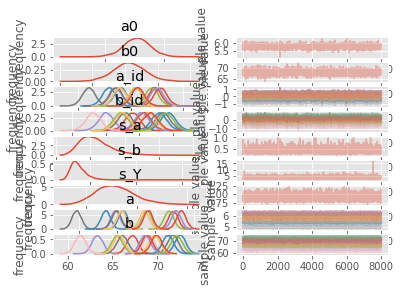

In [17]:
fig = fit.plot()

In [20]:
ms_a = fit.extract('a')['a']
ms_b = fit.extract('b')['b']

In [24]:
x = np.arange(18)
df_b = pd.DataFrame([])
for i in range(18):
    df_b[i] = ms_a[:, 0] * x[i] + ms_b[:, 0]

In [29]:
low_y50, high_y50 = mstats.mquantiles(df_b, [0.25, 0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025, 0.975], axis=0)


In [26]:
df_0 = groups.get_group(1)

In [27]:
df_0

,age,height,id
0,1,72.737927,1
1,3,85.694575,1
2,5,98.635829,1
3,8,117.302636,1
4,10,130.076144,1
5,15,162.717327,1
6,17,171.236888,1


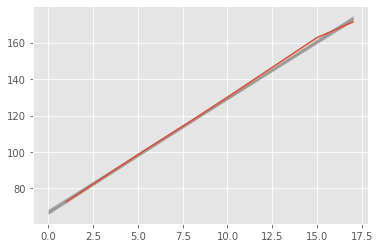

In [30]:
plt.plot(df_0.age, df_0.height)
plt.fill_between(x, low_y50, high_y50, alpha=0.6, color='darkgray')
plt.fill_between(x, low_y95, high_y95, alpha=0.6, color='gray')